In [46]:
import torch
import attr
from pathlib import Path
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
from sklearn import metrics as sk_metrics
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import json

In [47]:
@attr.s(auto_attribs=True)
class DataPreparation:
    data_dir: Path
    
    @staticmethod
    def data_transformations():
        data_transforms = {
            "test": transforms.Compose(
                [
                    transforms.CenterCrop((200, 1500)),
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ]
            )
        }
        return data_transforms

    def create_dataloaders(self, batch_size, shuffle, num_workers):
        data_transforms = self.data_transformations()

        image_datasets = {
            "test": datasets.ImageFolder(self.data_dir, data_transforms["test"])
        }
        dataloaders = {
            "test": torch.utils.data.DataLoader(
                image_datasets["test"],
                batch_size=batch_size,
                shuffle=shuffle,
                num_workers=num_workers,
            )
        }
        dataset_sizes = {"test": len(image_datasets["test"])}
        return dataloaders, dataset_sizes

In [48]:
DEVICE = 1

In [49]:
def get_model(variant, model_filename):
    model_path = (
        Path().cwd().parents[0] / f"models/label_{variant}/{model_filename}.pth"
    )
    model = torch.load(model_path, map_location=torch.device(DEVICE))
    model = model.eval()
    print(model_path)
    return model

In [50]:
def get_predictions_ground_truth(data, model):
    y_pred = []
    y_true = []
    y_scores_positive_class = []
    for i, (inputs, labels) in enumerate(data['test']):
        print(i, end="\r")
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        values, preds = torch.max(outputs, 1)
        y_pred.append(preds.cpu().numpy())
        y_true.append(labels.cpu().numpy())
        y_scores_positive_class.append(outputs.detach().cpu().numpy()[:,1])

    return np.concatenate(y_pred), np.concatenate(y_true), np.concatenate(y_scores_positive_class)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.58 µs


In [51]:
def create_confusion_matrix(y_true, y_pred, heartbeat_pos):
    fig = plt.figure()
    matrix = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap="Blues")
    filename = f"confusion_matrix_testing_{heartbeat_pos}_heartbeat"
    plt.savefig(filename)
    return filename

In [52]:
def roc_auc(y_true, y_scores_positive_class, heartbeat_pos):
    fpr, tpr, _ = sk_metrics.roc_curve(y_true, y_scores_positive_class)
    roc_auc = sk_metrics.roc_auc_score(y_true, y_scores_positive_class)
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.4f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    filename = f"roc_curve_{heartbeat_pos}_heartbeat"
    plt.savefig(filename)
    plt.show()
    return roc_auc, filename

In [53]:
def compute_metrics(y_true, y_pred):
    return (
        sk_metrics.accuracy_score(y_pred, y_true),
        sk_metrics.f1_score(y_pred, y_true),
        sk_metrics.precision_score(y_pred, y_true),
    )

In [54]:
def create_summ_dict(
    accuracy,
    f1,
    precision,
    confusion_path,
    auc_value,
    roc_path,
    heartbeat_pos,
    summary_dict,
):
    summary_dict[f"{heartbeat_pos}_heartbeat"] = {
        "accuracy": accuracy,
        "f1-score": f1,
        "precision": precision,
        "confusion_matrix_path": confusion_path,
        "roc_curve_path": roc_path,
    }
    return summary_dict

In [55]:
variants = ["final", "initial"]
models = ["resnet50_d_10_t_18_02", "resnet50_d_10_t_12_10"]

final resnet50_d_10_t_18_02
./models/label_final/resnet50_d_10_t_18_02.pth


<Figure size 432x288 with 0 Axes>

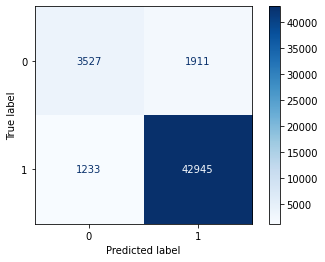

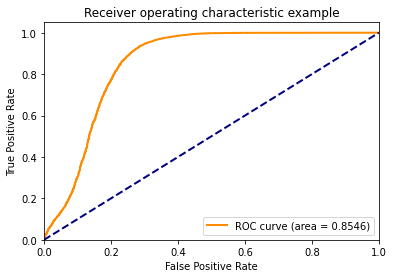

initial resnet50_d_10_t_12_10
./models/label_initial/resnet50_d_10_t_12_10.pth


<Figure size 432x288 with 0 Axes>

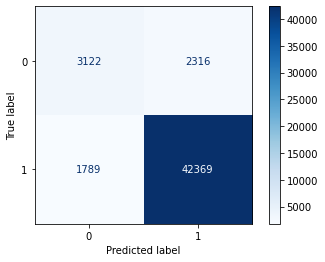

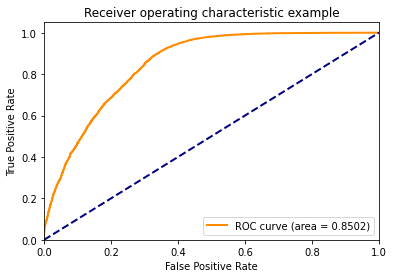

In [56]:
summary_dict = {}
for index in range(len(models)):
    data_prep = DataPreparation(f"../data/figures_{variants[index]}_complete/test")
    data, size = data_prep.create_dataloaders(16, False, 4)
    print(variants[index], models[index])
    y_pred, y_true, y_scores = get_predictions_ground_truth(
        data, get_model(variants[index], models[index])
    )
    summary_dict = create_summ_dict(
        *compute_metrics(y_true, y_pred),
        create_confusion_matrix(y_true, y_pred, variants[index]),
        *roc_auc(y_true, y_scores, variants[index]),
        variants[index],
        summary_dict,
    )

In [57]:
with open("metrics_summary.json", "w") as f:
    json.dump(summary_dict, f)